# Retrieval Challenge 2019 solution
## Single model CNN extraction + NN search
by Andres Torrubia 

Originally based on fastai starter pack by Dmytro Mishkin
https://www.kaggle.com/c/landmark-retrieval-2019/discussion/89660 

This notebook extracts the last convolution layer of a given architecture
applied GeM pooling and performs L2 normalization.

It uses augmentation (images are LR flipped) so both the index and queries features
are duplicated.

Once features are extracted, it performs regular nearest neighbour search using PCA, whitening and L2 normalization
and the resuls are ready for a submission.

It also saves the results of nearest neighbour search for ensembling (different notebook).

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="1"

import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
from arch import RingGeMNet, GeMNet, L2Norm, GeM
import re

from fastprogress import master_bar, progress_bar
%config InlineBackend.figure_format ='retina'

In [2]:
# ./index -> points to index dir
COMP_DATA_DIR = Path('.')

df = pd.DataFrame({'Image' : sorted(get_image_files(COMP_DATA_DIR / 'index', recurse=True))})

In [3]:
df.head()

Image
0  index/0/0/0/0000215a37942b17.jpg
1  index/0/0/0/00005baad2e46555.jpg
2  index/0/0/0/00007d3b7f15b575.jpg
3  index/0/0/0/00009069e8450638.jpg
4  index/0/0/0/00009574f46e9fd8.jpg

In [4]:
NUM_WORKERS=8
SIZE = 256
DO_FULL_SIZE = False 

class ImageListAbsPath(ImageList):
    def open(self, fn:PathOrStr)->Image:
        return open_image(fn.replace('./',''))
    
tfms = (None, None)
if DO_FULL_SIZE:
    BS=1
    data = (ImageList.from_df(df,path='', cols=['Image'])
            .split_none()
            .label_const()
            .transform(tfms, resize_method=ResizeMethod.NO)
            .databunch(bs=BS, num_workers=NUM_WORKERS)
            .normalize(imagenet_stats)
           ) 
    data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
    data.train_dl.dl.batch_sampler.drop_last = False
if not DO_FULL_SIZE:
    BS=64
    data = (ImageList.from_df(df,path='', cols=['Image'])
            .split_none()
            .label_const()
            .transform(tfms, resize_method=ResizeMethod.SQUISH, size=SIZE)
            .databunch(bs=BS, num_workers=NUM_WORKERS)
            .normalize(imagenet_stats)
           ) 
    data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
    data.train_dl.dl.batch_sampler.drop_last = False

In [5]:
import torchvision
import pretrainedmodels

In [6]:
arch = partial(pretrainedmodels.se_resnet152, num_classes=1000) 

arch.__name__ = arch.func.__name__
model_fname =  None #'resnet152_i200_l1000-256'
basename_suffix = 'cut-extractor-2scales6patches-gem3'
size_fname = 'full' if DO_FULL_SIZE else str(SIZE)

basename = f'{model_fname or arch.__name__}_{size_fname}_{basename_suffix}.pth'
print(basename)

se_resnet152_256_cut-extractor-2scales6patches-gem3.pth


In [7]:
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.l2norm = L2Norm()
        self.pool   = GeM(3.) #nn.AdaptiveMaxPool2d(1)
    def forward(self, x):
        b,d,ny,nx = x.shape
        
        f0  = self.l2norm(self.pool(x)).view(b,1,d)
        # uncomment if you want to extract multiple patches here
        
        #f1  = self.l2norm(self.pool(x[...,ny//2-ny//4:ny//2+ny//4,nx//2-nx//4:nx//2+nx//4])).view(b,1,d)

        #f1_x0y0 = self.l2norm(self.pool(x[...,:ny//2,:nx//2])).view(b,1,d)
        #f1_x0y1 = self.l2norm(self.pool(x[...,ny//2:,:nx//2])).view(b,1,d)
        #f1_x1y0 = self.l2norm(self.pool(x[...,:ny//2,nx//2:])).view(b,1,d)
        #f1_x1y1 = self.l2norm(self.pool(x[...,ny//2:,nx//2:])).view(b,1,d)
        
        #return torch.cat((f0,f1,f1_x0y0,f1_x0y1,f1_x1y0,f1_x1y1), dim=1)
        #return torch.cat((f0,f1), dim=1)
        
        return f0

In [8]:
learn = cnn_learner(data, arch,pretrained='imagenet', custom_head=Extractor(),
                   metrics=[accuracy], cut= -1,
                   loss_func=nn.CrossEntropyLoss())

In [9]:
if model_fname:
    learn = learn.load(model_fname, strict=False)
else:
    model_fname = arch.__name__


In [10]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________

In [11]:
InferenceNet =  learn.model

In [12]:
NUM_WORKERS=16

qdf = pd.DataFrame({'Image' : sorted(get_image_files(COMP_DATA_DIR / 'test', recurse=True))})
qdf.head()

Image
0  test/0/0/0/00016575233bc956.jpg
1  test/0/0/0/0001aadbcd8cb923.jpg
2  test/0/0/0/0002c06b2440a5f9.jpg
3  test/0/0/0/0002eb1ee5a5a6b2.jpg
4  test/0/0/0/000594dad986513e.jpg

In [13]:
BS=1 if DO_FULL_SIZE else 64
qdata = (ImageList.from_df(qdf,path='', cols=['Image'])
        .split_none()
        .label_const()
        .transform(tfms, 
                   resize_method=ResizeMethod.NO if DO_FULL_SIZE else ResizeMethod.SQUISH, 
                   size=None if DO_FULL_SIZE else SIZE)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats)
       ) 
qdata.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(qdata.train_ds)
qdata.train_dl.dl.batch_sampler.drop_last = False

In [14]:
def extract_vectors_batched(data,model,flip=False):
    model.cuda()
    model.eval()
    n_flip = 2 if flip else 1
    n_img = len(data.train_ds) * n_flip
    bs = data.batch_size
    vectors = None

    with torch.no_grad():
        for idx, (img,label) in enumerate(progress_bar(data.train_dl)):
            st=idx*bs*n_flip
            fin=min((idx+1)*bs*n_flip, n_img)
            if flip:
                img = torch.cat((img,img.flip([3])))
            out = model(img).cpu()
            if vectors is None: vectors = torch.zeros(n_img, *out.shape[1:])
            if flip:
                n = fin - st
                vectors[st:fin:2    ,...] = out[:n//2,...]
                vectors[st+1:fin+1:2,...] = out[n//2:,...]
            else:
                vectors[st:fin,...] = out
    return vectors

# for multiple patches, wip
def extract_vectors_batched_multi(data,model):
    model.cuda()
    model.eval()
    n_img = len(data.train_ds)
    bs = data.batch_size
    vectors = None
    #hook = hook_outputs([learn.model[8]])#, learn.model[6]))
    
    #extractor = Extractor().cuda().eval()

    with torch.no_grad():
        for idx, (img,label) in enumerate(progress_bar(data.train_dl)):
            st=idx*bs
            fin=min((idx+1)*bs, n_img)
            layer_output = model(img).cpu()
            if vectors is None:
                vectors = [torch.zeros(n_img, layer_output.shape[1]) for layer_output in hook.stored]
            vectors[st:fin,...] = layer_output

            for i, layer_output in enumerate(hook.stored):
                vectors[i][st:fin,...] = extractor(layer_output)
    return vectors

In [15]:
flip = True
p_flip = 'flip' if flip else ''
try:
    query_features = torch.load( f'query{p_flip}_{basename}')
except:
    query_features = extract_vectors_batched(qdata,InferenceNet, flip)
    torch.save(query_features, f'query{p_flip}_{basename}')
try:
    index_features = torch.load( f'index{p_flip}_{basename}')
except:
    index_features = extract_vectors_batched(data, InferenceNet, flip)
    torch.save(index_features, f'index{p_flip}_{basename}')


In [16]:
query_features, index_features

(tensor([[[3.9447e-03, 2.3069e-03, 3.0117e-04,  ..., 2.7599e-08,
           1.2408e-03, 2.7599e-08]],
 
         [[9.8946e-03, 1.1611e-02, 1.7028e-04,  ..., 8.6921e-04,
           2.7619e-08, 2.7619e-08]],
 
         [[2.4467e-05, 1.8179e-05, 3.3628e-03,  ..., 4.6086e-05,
           3.1301e-08, 3.1301e-08]],
 
         ...,
 
         [[3.0407e-02, 2.8238e-02, 4.6179e-03,  ..., 2.7111e-02,
           7.6268e-03, 5.8514e-03]],
 
         [[6.8623e-04, 5.6674e-03, 3.9859e-04,  ..., 8.0543e-03,
           1.0459e-02, 1.7603e-05]],
 
         [[1.6234e-03, 5.6111e-03, 2.6926e-08,  ..., 1.2082e-03,
           1.0421e-02, 1.2131e-04]]]),
 tensor([[[3.3112e-08, 1.3516e-03, 3.3112e-08,  ..., 8.9854e-04,
           5.7335e-02, 1.1058e-03]],
 
         [[3.2704e-08, 4.5579e-03, 3.2704e-08,  ..., 3.2704e-08,
           1.4839e-02, 1.5566e-03]],
 
         [[1.5336e-02, 1.3680e-03, 2.5718e-04,  ..., 5.8875e-03,
           6.0742e-03, 8.7786e-03]],
 
         ...,
 
         [[1.6882e-03, 2.6726e-0

In [39]:
import faiss
def flatten(list2d): return list(itertools.chain(*list2d))

# duplicate b/c we're going to have image, image_LR, image, image_LR, ...
query_fnames = flatten([[x.stem, x.stem] for x in qdf.Image.tolist()])
index_fnames = [x.stem for x in df.Image.tolist()]


In [18]:
learn, InferenceNet, co, res, flat_config, cpu_index, index = None, None, None, None, None, None, None
gc.collect()
torch.cuda.empty_cache()

In [19]:
def t_pcawhitenlearn(X):

    N = X.shape[0]

    # Learning PCA w/o annotations
    m = X.mean(dim=0, keepdim=True)
    Xc = X - m
    Xcov = Xc.t() @ Xc
    Xcov = (Xcov + Xcov.t()) / (2*N)
    eigval, eigvec = torch.symeig(Xcov,eigenvectors=True)
    order = eigval.argsort(descending=True)
    eigval = eigval[order]
    eigvec = eigvec[:, order]

    P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()
    
    return m, P

def t_whitenapply(X, m, P, dimensions=None):
    
    if not dimensions: dimensions = P.shape[1]

    X = (X-m) @ P[:,:dimensions]
    X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-6)
    return X

def get_idxs_and_dists(_query_features, _index_features, index_type='', BS = 32):
    
    # if I do PCA and whitenining here I get different results than if doing it by faiss, why?
    # hence I had to disable it and use faiss which resorts to CPU then (slower)
    if False:
        index_transforms = []
        for index_transform in index_type.split(','):
            m = re.match(r'PCAW(\d+)?', index_transform)
            if m is not None:
                dimensions = int(m[1]) if m[1] is not None else _index_features.shape[-1]
                print(f"Applying {dimensions} PCA, Whitening and L2Norm...", end="")
                m, P = t_pcawhitenlearn(_index_features)
                _index_features = t_whitenapply(_index_features, m, P,dimensions=dimensions).unsqueeze(1)
                _query_features = t_whitenapply(_query_features, m, P,dimensions=dimensions).unsqueeze(1)
                print("done")

            elif index_transform not in ['L2norm']: index_transforms.append(index_transform)

        index_type = ','.join(index_transforms)
        print(index_type)
    else:
         _index_features = _index_features.unsqueeze(1)
         _query_features = _query_features.unsqueeze(1)
        
    if isinstance(_query_features, Tensor): query_features = _query_features.numpy()
    if isinstance(_index_features, Tensor): index_features = _index_features.numpy()
    max_hits = 200
    
    n_patches = query_features.shape[1]
    n_queries = query_features.shape[0]

    query_features = query_features[:,::n_patches,:].squeeze(1).copy()
    index_features = index_features[:,::n_patches,:].squeeze(1).copy()    
    n_patches = 1

    print(query_features.shape, index_features.shape, n_queries, n_patches)
    
    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.device = 0
    res = faiss.StandardGpuResources()
    co = faiss.GpuMultipleClonerOptions()
    co.shard=True
    co.shard_type=1
    co.useFloat16=True
    _index = faiss.index_factory(index_features.shape[1], index_type)#, faiss.METRIC_INNER_PRODUCT)
    try:
        faiss.index_cpu_to_all_gpus(_index,co=co)
        print("Index in GPU")
    except:
        index = _index
        print("Index in CPU")
    print("Training index...", end="")
    index.train(index_features)
    print("done")
    print("Adding features to index...", end="")
    index.add(index_features)
    print("done")
    out_dists = np.zeros((len(query_features), max_hits), dtype=np.float32)
    out_idxs  = np.zeros((len(query_features), max_hits), dtype=np.int32)
    NUM_QUERY = len (query_features)
    for ind in progress_bar(range(0, len(query_features), BS)):
        fin = ind+BS
        if fin > NUM_QUERY: fin = NUM_QUERY
        q_descs = query_features[ind:fin]
        D, I = index.search(q_descs, max_hits)
        out_dists[ind:fin] = D
        out_idxs[ind:fin] = I // n_patches
    return out_idxs, out_dists

In [20]:
faiss.omp_get_max_threads()

16

In [21]:
query_features.shape

torch.Size([235154, 1, 2048])

In [ ]:
index_type=f"PCAW{query_features.shape[-1]},L2norm,Flat"

try:
    out_idxs  = np.load(f'idx_{basename}.npy')
    out_dists = np.load(f'dist_{basename}.npy')
except:
    out_idxs, out_dists = get_idxs_and_dists(
        query_features.squeeze(1), 
        index_features.squeeze(1), BS = 32, index_type=index_type)
    np.save(f'idx_{basename}.npy',  out_idxs)
    np.save(f'dist_{basename}.npy', out_dists)

In [ ]:
np.sort(out_dists.reshape((-1,int(out_idxs.shape[1]*1))), axis=1)

In [28]:
out_idxs.shape, out_dists.shape

((235154, 200), (235154, 200))

In [50]:
sub_fname = 'test_submission.csv'
sample_df = pd.read_csv('test.csv')
sample_df['images'] = ''

In [51]:
sub = {}
for i, query_fname in progress_bar(enumerate(query_fnames), total=len(query_fnames)):
    if i % 2: continue
    idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
    dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0) 
    u_idx = np.unique(idx,return_index=True)[1]
    i_dst = dst[u_idx]
    o_dst =np.argsort(i_dst)
    _out_idxs = idx[u_idx[o_dst]]

    ids = [index_fnames[x] for x in _out_idxs[:100]]
    sub[query_fname] = ' '.join(ids)

In [52]:
sub_df = pd.DataFrame({'id' : list(sub.keys()), 'images':list(sub.values())})
sub_df = pd.concat([sub_df, sample_df]).drop_duplicates(subset=['id'])
sub_df.to_csv(sub_fname, index=False)

In [53]:
sub_df.iloc[:8]

id                                             images
0  00016575233bc956  5876d21120fdd13f 32c32c3d11a87a4c ee5ba16733f8...
1  0001aadbcd8cb923  67ccb2f27348a45c c3659d7b8a9abcc9 dae47db2c965...
2  0002c06b2440a5f9  c5fcd16506f93e07 eb04cb8049a108a9 01f8834279b8...
3  0002eb1ee5a5a6b2  db70274b4eab635b 4a0dcde28b4d95be 60a7fbda8d6e...
4  000594dad986513e  4cd7b26f93063e45 18047c33a5c96d35 80398226cbd2...
5  0006b7eb42bc7ee2  2c78d265870173d4 c9c31b63b7a49ad9 37edc1da3daa...
6  00084cdf8f600d00  a3e173dd1c9c201e f0b512f7a0bbd010 723ba9be9227...
7  0008722c48c52fda  55abbf45eaa76eb9 6a598a3499349053 af6a2cedb474...

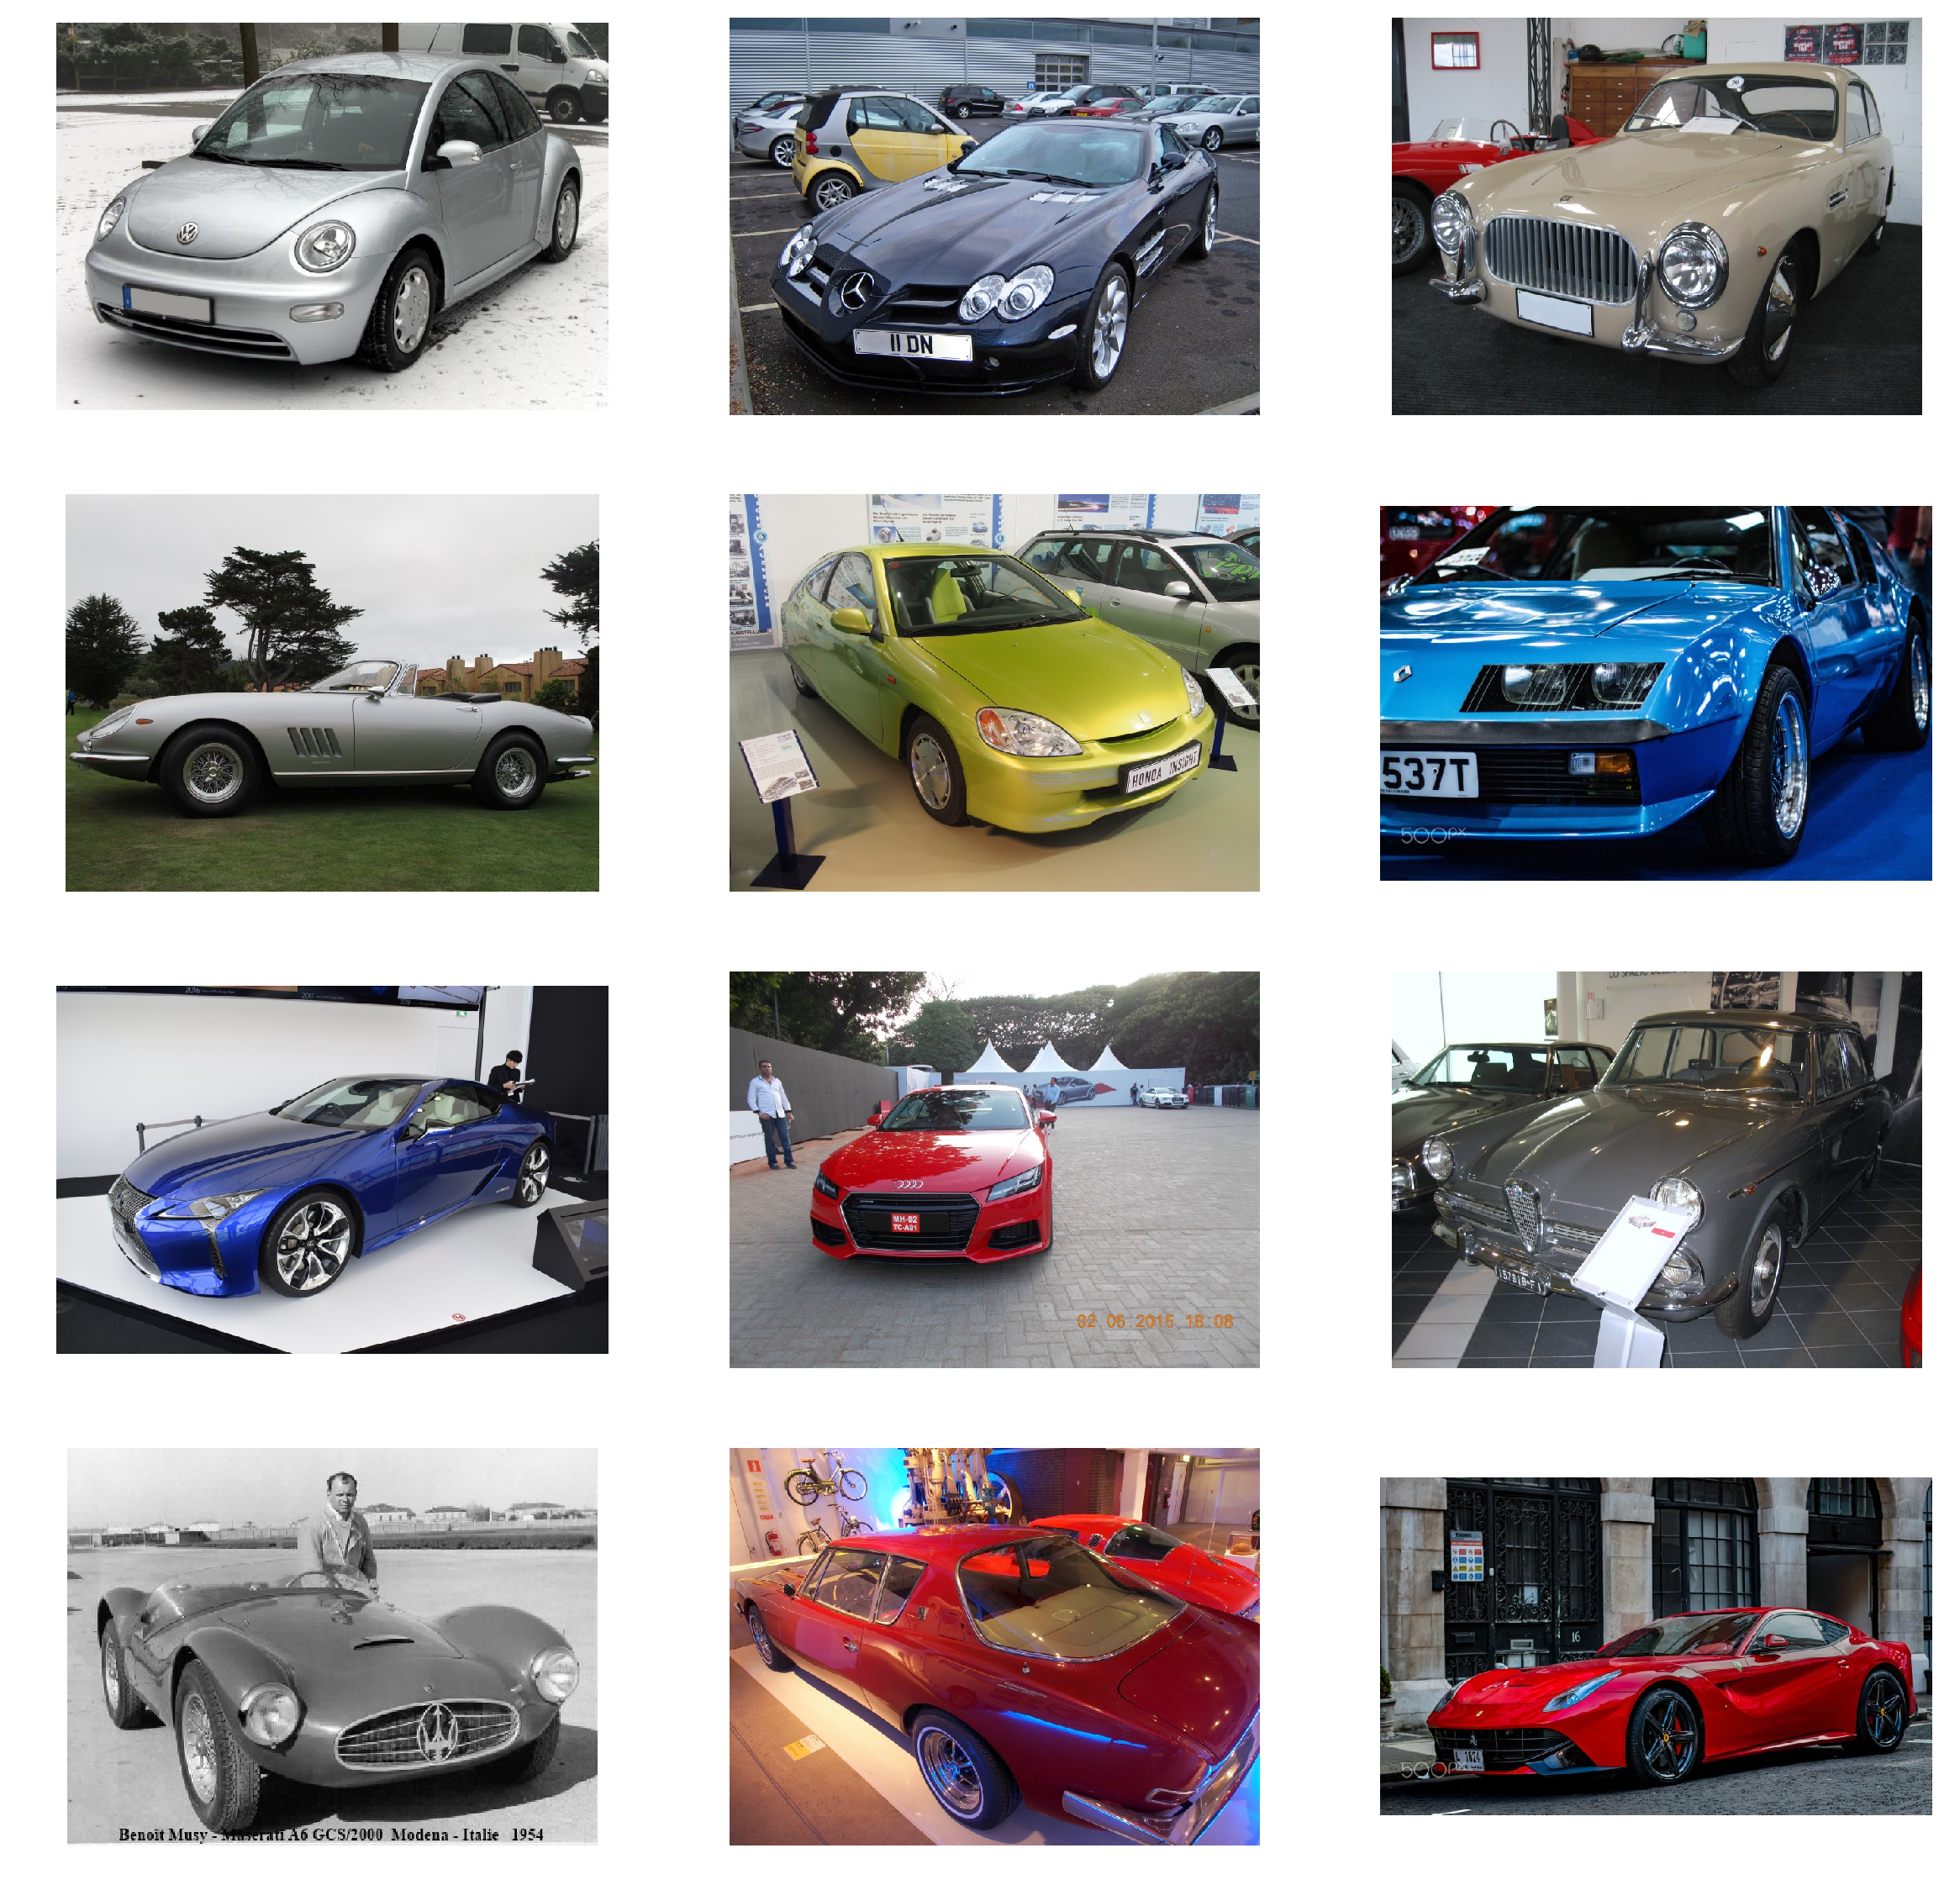

In [54]:
def fix_path(p):
    fn = str(p.name)
    return p.parent / fn[0] / fn[1] / fn[2] / fn
def image_results(row, n= 12):
    r = [open_image(fix_path(Path('test') / (row.id + '.jpg')))]
    r.extend([open_image(fix_path(Path('index') / (id + '.jpg'))) for id in row.images.split(' ')[:n]])
    return r
show_all(image_results(sub_df.iloc[3]),r=4,figsize=(20, 20))

In [55]:
basename

'se_resnet152_256_cut-extractor-2scales6patches-gem3.pth'

In [59]:
!kaggle competitions submit -c landmark-retrieval-2019 -f {sub_fname} -m '{basename} {index_type}'


100%|████████████████████████████████████████| 193M/193M [00:07<00:00, 26.5MB/s]
Successfully submitted to Google Landmark Retrieval 2019

In [58]:
sub_fname

'test_submission.csv'

In [60]:
import time
time.sleep(10)

In [61]:
!kaggle competitions submissions -c landmark-retrieval-2019 -v > submissions.csv

In [62]:
submissions = pd.read_csv('submissions.csv')
submissions.iloc[0].publicScore

'0.04208'